In [8]:
# %%
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torchvision.models import ResNet50_Weights # Use recommended weights enum
from torch.utils.data import DataLoader, random_split, Subset
from sklearn.metrics import classification_report, confusion_matrix
from torch.cuda.amp import GradScaler, autocast # For mixed precision
import numpy as np
import cv2
import os
import imutils # Ensure installed: pip install imutils
from tqdm.notebook import tqdm # Progress bars for Jupyter
import time
import copy
import matplotlib.pyplot as plt

print("Libraries imported.")

Libraries imported.


In [9]:
# %%
# --- Directories ---
# Assumes your original data is in './Training/class1', './Training/class2', etc.
# Modify if your structure is different (e.g., '/kaggle/input/your_dataset/Training')
INPUT_TRAIN_DIR = './Training' # <--- Point this to your ORIGINAL training data directory

# Directory where preprocessed images will be saved
OUTPUT_PREPROC_DIR = './Training_preproc'

# --- Preprocessing Parameters ---
# Target size for images AFTER preprocessing and BEFORE transforms
# Should match the input size expected by the model
IMG_SIZE = 224

# --- Model & Training Parameters ---
NUM_CLASSES = 4       # Adjust based on your dataset (glioma, meningioma, notumor, pituitary)
BATCH_SIZE = 32
NUM_EPOCHS = 25       # Adjust as needed
LEARNING_RATE = 0.001
VAL_SPLIT = 0.2       # 20% of the data for validation

# --- Device Setup ---
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# Enable cuDNN benchmark for potential speedup on GPU
if torch.cuda.is_available():
    torch.backends.cudnn.benchmark = True
    print("cuDNN Benchmark enabled.")

# --- Model Saving ---
MODEL_SAVE_PATH = 'resnet50_tumor_classifier_best_val_acc.pth'

# --- Reproducibility ---
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

print("Configuration set.")

Using device: cuda:0
cuDNN Benchmark enabled.
Configuration set.


In [10]:
# %%
# --- Define the Cropping Function (from original notebook) ---
def crop_img(img, target_size):
    """
    Finds the presumed tumor area based on contours, crops, and resizes the image.
    Handles grayscale, color, and alpha channel images.
    Returns None if cropping or resizing fails critically.
    """
    # Input validation
    if img is None:
        print("Warning: crop_img received a None image.")
        return None
    if not isinstance(img, np.ndarray) or img.ndim < 2:
         print(f"Warning: crop_img received invalid image data type/dims: {type(img)}, ndim={img.ndim if isinstance(img, np.ndarray) else 'N/A'}")
         return None
    if img.shape[0] <= 0 or img.shape[1] <= 0:
        print(f"Warning: crop_img received image with invalid dimensions: {img.shape}")
        return None

    # Ensure image is BGR
    if len(img.shape) == 2 or img.shape[2] == 1: # Grayscale
        img_bgr = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    elif img.shape[2] == 4: # BGRA
        img_bgr = cv2.cvtColor(img, cv2.COLOR_BGRA2BGR)
    elif img.shape[2] == 3: # BGR
        img_bgr = img
    else:
        print(f"Warning: Unsupported number of channels ({img.shape[2]}) in image. Cannot process.")
        # Fallback: Resize original image if dimensions are valid
        try:
            return cv2.resize(img, (target_size, target_size))
        except Exception as e:
            print(f"  Fallback resize also failed: {e}")
            return None


    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # Thresholding
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)

    # Fallback: If no contours, resize the original BGR image
    if not cnts:
        print("Warning: No contours found. Resizing original image.")
        try:
            return cv2.resize(img_bgr, (target_size, target_size))
        except Exception as e:
             print(f"  Fallback resize failed for no-contour image: {e}")
             return None # Indicate failure

    # Find the largest contour and its bounding box
    c = max(cnts, key=cv2.contourArea)
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])

    # Crop using bounding box coordinates (with bounds checking)
    ADD_PIXELS = 0 # Optional buffer
    top = max(0, extTop[1] - ADD_PIXELS)
    bottom = min(img_bgr.shape[0], extBot[1] + ADD_PIXELS)
    left = max(0, extLeft[0] - ADD_PIXELS)
    right = min(img_bgr.shape[1], extRight[0] + ADD_PIXELS)

    # Validate crop dimensions
    if top >= bottom or left >= right:
        print(f"Warning: Invalid crop dimensions calculated ({top}:{bottom}, {left}:{right}). Resizing original image.")
        try:
            return cv2.resize(img_bgr, (target_size, target_size))
        except Exception as e:
             print(f"  Fallback resize failed for invalid crop dims: {e}")
             return None # Indicate failure

    cropped_img = img_bgr[top:bottom, left:right].copy()

    # Final resize of the cropped image
    try:
        resized_img = cv2.resize(cropped_img, (target_size, target_size))
        return resized_img
    except Exception as e:
        print(f"Error resizing cropped image: {e}. Image shape was {cropped_img.shape}")
        # Attempt to resize original as last resort
        try:
             print("  Attempting resize of original image instead.")
             return cv2.resize(img_bgr, (target_size, target_size))
        except Exception as e_orig:
             print(f"    Resize of original image also failed: {e_orig}")
             return None # Indicate critical failure


# --- Main Preprocessing Logic ---
print(f"\nStarting preprocessing...")
print(f"Input directory: {INPUT_TRAIN_DIR}")
print(f"Output directory: {OUTPUT_PREPROC_DIR}")
print(f"Target image size: {IMG_SIZE}x{IMG_SIZE}")

# We only process the 'Training' data as per the request focus
dataset_type = 'Training' # Focus only on training data for train/val split later
input_dir_path = INPUT_TRAIN_DIR # Use the base training dir
output_dir_path_base = os.path.join(OUTPUT_PREPROC_DIR, dataset_type)

print(f"\nProcessing dataset type: {dataset_type}")
if not os.path.isdir(input_dir_path):
    print(f"ERROR: Input directory not found: {input_dir_path}. Please check the INPUT_TRAIN_DIR path.")
    # Optional: raise an error here if needed
    # raise FileNotFoundError(f"Input directory not found: {input_dir_path}")
else:
    sub_dirs = [d for d in os.listdir(input_dir_path) if os.path.isdir(os.path.join(input_dir_path, d))]
    if not sub_dirs:
         print(f"ERROR: No class subdirectories found in {input_dir_path}.")
         # Optional: raise an error
    else:
        print(f"Found class subdirectories: {sub_dirs}")

        for class_dir in tqdm(sub_dirs, desc=f"Processing classes in {dataset_type}"):
            input_class_path = os.path.join(input_dir_path, class_dir)
            output_class_path = os.path.join(output_dir_path_base, class_dir)

            if not os.path.exists(output_class_path):
                os.makedirs(output_class_path)
                print(f"Created output directory: {output_class_path}")

            image_files = [f for f in os.listdir(input_class_path) if os.path.isfile(os.path.join(input_class_path, f))]

            num_processed = 0
            num_skipped = 0
            for img_file in tqdm(image_files, desc=f"  Processing images in {class_dir}", leave=False):
                input_img_path = os.path.join(input_class_path, img_file)
                output_img_path = os.path.join(output_class_path, img_file)

                # Optional: Skip if already processed
                # if os.path.exists(output_img_path):
                #    continue

                try:
                    image = cv2.imread(input_img_path)
                    if image is None:
                        print(f"Warning: Could not read image {input_img_path}. Skipping.")
                        num_skipped += 1
                        continue

                    # Crop and resize
                    processed_img = crop_img(image, IMG_SIZE)

                    if processed_img is None:
                         print(f"Warning: Preprocessing failed for image {input_img_path}. Skipping save.")
                         num_skipped += 1
                         continue

                    # Save the processed image
                    success = cv2.imwrite(output_img_path, processed_img)
                    if not success:
                        print(f"Warning: Failed to write processed image to {output_img_path}. Skipping.")
                        num_skipped += 1
                    else:
                         num_processed += 1

                except Exception as e:
                    print(f"Error processing image {input_img_path}: {e}")
                    num_skipped += 1
            print(f"  Finished class {class_dir}: Processed={num_processed}, Skipped/Errors={num_skipped}")

    print(f"\nPreprocessing for '{dataset_type}' complete. Processed images saved to: {output_dir_path_base}")


Starting preprocessing...
Input directory: ./Training
Output directory: ./Training_preproc
Target image size: 224x224

Processing dataset type: Training
Found class subdirectories: ['notumor', 'glioma', 'pituitary', 'meningioma']


Processing classes in Training:   0%|          | 0/4 [00:00<?, ?it/s]

Created output directory: ./Training_preproc/Training/notumor


  Processing images in notumor:   0%|          | 0/1745 [00:00<?, ?it/s]

  Finished class notumor: Processed=1745, Skipped/Errors=0
Created output directory: ./Training_preproc/Training/glioma


  Processing images in glioma:   0%|          | 0/1441 [00:00<?, ?it/s]

  Finished class glioma: Processed=1441, Skipped/Errors=0
Created output directory: ./Training_preproc/Training/pituitary


  Processing images in pituitary:   0%|          | 0/1577 [00:00<?, ?it/s]

  Finished class pituitary: Processed=1577, Skipped/Errors=0
Created output directory: ./Training_preproc/Training/meningioma


  Processing images in meningioma:   0%|          | 0/1459 [00:00<?, ?it/s]

  Finished class meningioma: Processed=1459, Skipped/Errors=0

Preprocessing for 'Training' complete. Processed images saved to: ./Training_preproc/Training


In [11]:
# %%
# Define transforms for training (with augmentation) and validation (no augmentation)
# Using ImageNet mean and std is standard practice for pre-trained models
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]

data_transforms = {
    'train': transforms.Compose([
        # Augmentations
        transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8, 1.0)), # Crop a random portion and resize
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, hue=0.1),
        # Basic Preprocessing
        transforms.ToTensor(), # Convert PIL Image to tensor
        transforms.Normalize(imagenet_mean, imagenet_std) # Normalize with ImageNet stats
    ]),
    'val': transforms.Compose([
        # Validation: Only resize, center crop, and normalize
        transforms.Resize(IMG_SIZE + 32), # Resize slightly larger than target
        transforms.CenterCrop(IMG_SIZE), # Crop the center to target size
        transforms.ToTensor(),
        transforms.Normalize(imagenet_mean, imagenet_std)
    ])
}

print("Training and Validation data transforms defined.")

Training and Validation data transforms defined.


In [12]:
# %%
# --- Load Data Using the PREPROCESSED Path ---
# This is the directory created by the preprocessing step
PREPROCESSED_TRAIN_DATA_DIR = os.path.join(OUTPUT_PREPROC_DIR, 'Training')

print(f"Loading data from PREPROCESSED directory: {PREPROCESSED_TRAIN_DATA_DIR}")

# We need TWO dataset instances pointing to the SAME preprocessed data,
# but applying DIFFERENT transforms.
try:
    # Dataset instance for applying TRAINING transforms
    full_dataset_train_transforms = datasets.ImageFolder(PREPROCESSED_TRAIN_DATA_DIR,
                                                        transform=data_transforms['train'])

    # Dataset instance for applying VALIDATION transforms
    full_dataset_val_transforms = datasets.ImageFolder(PREPROCESSED_TRAIN_DATA_DIR,
                                                      transform=data_transforms['val'])

    print(f"Successfully loaded PREPROCESSED dataset structure.")
    print(f"Total images found: {len(full_dataset_train_transforms)}") # Length should be the same

    # Get class names and mapping - crucial for metrics and model output layer
    DETECTED_CLASSES = full_dataset_train_transforms.classes
    CLASS_TO_IDX = full_dataset_train_transforms.class_to_idx
    IDX_TO_CLASS = {v: k for k, v in CLASS_TO_IDX.items()}
    print(f"Classes detected: {DETECTED_CLASSES}")
    print(f"Class to index mapping: {CLASS_TO_IDX}")

    # Verify NUM_CLASSES matches detected classes
    if NUM_CLASSES != len(DETECTED_CLASSES):
         print(f"WARNING: NUM_CLASSES in config ({NUM_CLASSES}) does not match detected classes ({len(DETECTED_CLASSES)}). Adjust NUM_CLASSES.")
         # Potentially update NUM_CLASSES here automatically, or raise error
         # NUM_CLASSES = len(DETECTED_CLASSES)
         # print(f"Updated NUM_CLASSES to {NUM_CLASSES}")


except FileNotFoundError:
    print(f"ERROR: PREPROCESSED dataset folder not found at '{PREPROCESSED_TRAIN_DATA_DIR}'.")
    print("Did the preprocessing step (Cell 6) complete successfully and create this directory?")
    raise # Stop execution if data isn't found
except Exception as e:
    print(f"An error occurred loading the PREPROCESSED dataset: {e}")
    raise

# --- Split the Data ---
dataset_size = len(full_dataset_train_transforms)
val_size = int(VAL_SPLIT * dataset_size)
train_size = dataset_size - val_size
print(f"\nSplitting dataset:")
print(f"  Total samples: {dataset_size}")
print(f"  Training samples: {train_size}")
print(f"  Validation samples: {val_size}")

# Create indices for splitting
indices = list(range(dataset_size))
# We shuffle indices BEFORE splitting
np.random.shuffle(indices) # Uses the SEED set earlier
train_indices, val_indices = indices[:train_size], indices[train_size:]

# Create Subset datasets using the indices AND the appropriate transform dataset
# Training subset uses the dataset with training transforms
train_dataset_subset = Subset(full_dataset_train_transforms, train_indices)
# Validation subset uses the dataset with validation transforms
val_dataset_subset = Subset(full_dataset_val_transforms, val_indices)

# --- Create DataLoaders ---
# Use num_workers > 0 for faster data loading if possible (adjust based on system)
# Use pin_memory=True if using GPU for potential speedup
num_workers = os.cpu_count() // 2 if os.cpu_count() else 2 # Heuristic
pin_memory = True if DEVICE.type == 'cuda' else False

dataloaders = {
    'train': DataLoader(train_dataset_subset, batch_size=BATCH_SIZE, shuffle=True,
                        num_workers=num_workers, pin_memory=pin_memory),
    'val': DataLoader(val_dataset_subset, batch_size=BATCH_SIZE, shuffle=False, # No shuffle for validation
                      num_workers=num_workers, pin_memory=pin_memory)
}
dataset_sizes = {'train': len(train_dataset_subset), 'val': len(val_dataset_subset)}

print(f"\nDataLoaders created for training and validation.")
print(f"Using num_workers={num_workers}, pin_memory={pin_memory}")

Loading data from PREPROCESSED directory: ./Training_preproc/Training
Successfully loaded PREPROCESSED dataset structure.
Total images found: 6222
Classes detected: ['glioma', 'meningioma', 'notumor', 'pituitary']
Class to index mapping: {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}

Splitting dataset:
  Total samples: 6222
  Training samples: 4978
  Validation samples: 1244

DataLoaders created for training and validation.
Using num_workers=6, pin_memory=True


In [13]:
# %%
print("Loading ResNet50 model for Fine-Tuning...")

# --- FINE-TUNING Step 1: Load pre-trained weights ---
# Load a ResNet50 model using pre-trained weights from ImageNet
# Using DEFAULT is generally recommended for the latest best weights
try:
    # Option 1: Use pre-trained weights (recommended for fine-tuning)
    model = models.resnet50(weights=ResNet50_Weights.DEFAULT) # <<< CHANGED
    print("Loaded ResNet50 with DEFAULT pre-trained weights (ImageNet).")

    # Option 2: If DEFAULT causes issues, try the older V1 weights
    # model = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
    # print("Loaded ResNet50 with IMAGENET1K_V1 pre-trained weights.")

except Exception as e:
    print(f"Could not load pre-trained ResNet50 weights: {e}. Aborting.")
    raise

# --- FINE-TUNING Step 2: Freeze backbone parameters ---
# (Strategy 1: Freeze feature extractor, train only the head)
# If you want to train *all* layers (Strategy 2), comment out this block.
print("Freezing parameters of pre-trained layers...")
for param in model.parameters():
    param.requires_grad = False # Freeze all layers initially
print("Done freezing.")

# --- FINE-TUNING Step 3: Replace the final classifier layer ---
# Get the number of input features for the original classifier layer
num_ftrs = model.fc.in_features
print(f"Original classifier input features: {num_ftrs}")

# Create a new final layer matching the number of your classes (NUM_CLASSES)
# Parameters of newly constructed modules have requires_grad=True by default.
try:
    model.fc = nn.Linear(num_ftrs, NUM_CLASSES) # Replace the head
    print(f"Replaced final layer (model.fc): Input features={num_ftrs}, Output classes={NUM_CLASSES}")
    print(f"New classifier layer parameters require gradients: {model.fc.weight.requires_grad}")
except NameError:
     print("ERROR: NUM_CLASSES not defined. Was the Configuration cell run?")
     raise
except AttributeError:
     print("ERROR: Could not find 'fc' layer in the model. Is it the correct ResNet model?")
     raise

# Move the model to the specified device (GPU or CPU)
model = model.to(DEVICE)
print(f"Model (ready for fine-tuning) moved to device: {DEVICE}")

# --- Optional: Verify which parameters require gradients ---
print("\nParameters that require gradients (should be only the new fc layer):")
params_to_update = []
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"\t{name}")
        params_to_update.append(param)
# Make sure only model.fc.weight and model.fc.bias are listed above if freezing!

Loading ResNet50 model for Fine-Tuning...
Loaded ResNet50 with DEFAULT pre-trained weights (ImageNet).
Freezing parameters of pre-trained layers...
Done freezing.
Original classifier input features: 2048
Replaced final layer (model.fc): Input features=2048, Output classes=4
New classifier layer parameters require gradients: True
Model (ready for fine-tuning) moved to device: cuda:0

Parameters that require gradients (should be only the new fc layer):
	fc.weight
	fc.bias


In [16]:
# %%
# Loss Function (suitable for multi-class classification)
criterion = nn.CrossEntropyLoss()
print(f"Loss function: {criterion}")

# --- FINE-TUNING Step 4: Configure the Optimizer ---
# Pass only the parameters of the layers to be trained to the optimizer.

# Strategy 1: Train only the new classifier head (model.fc)
# First, ensure we identified the parameters correctly in the previous cell
print("Configuring optimizer for the new classifier layer (model.fc) only...")
params_to_optimize = []
for name, param in model.named_parameters():
    if param.requires_grad:
        params_to_optimize.append(param)
        print(f"  Adding param to optimizer: {name}")

if not params_to_optimize:
     # This happens if you didn't replace the head or uncommented the freezing block
     print("\nWARNING: No parameters require gradients! Falling back to optimizing all parameters.")
     print("         If fine-tuning the head was intended, check the freezing logic in the model definition cell.")
     optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
     print(f"Optimizer (fallback): Adam (lr={LEARNING_RATE}) - Optimizing ALL parameters")
else:
     optimizer = optim.Adam(params_to_optimize, lr=LEARNING_RATE)
     print(f"Optimizer: Adam (lr={LEARNING_RATE}) - Optimizing selected parameters")


# Strategy 2: Train all layers (load pre-trained weights, but don't freeze)
# If you commented out the freezing block in the previous cell, use this:
# print("Configuring optimizer to fine-tune ALL layers...")
# optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE) # Adjust LEARNING_RATE - often lower for fine-tuning all layers (e.g., 0.0001)
# print(f"Optimizer: Adam (lr={LEARNING_RATE}) - Optimizing ALL parameters")
#-----------------------------------------------------------------------------


# Learning Rate Scheduler (Optional but often helpful)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5) # Added verbose=True
print(f"Scheduler: ReduceLROnPlateau (factor=0.1, patience=5, monitoring val_loss)")

# Initialize GradScaler for Mixed Precision Training
# Note: The warning about deprecation is normal if using slightly older PyTorch/CUDA versions
scaler = GradScaler(enabled=(DEVICE.type == 'cuda'))
print(f"Mixed Precision GradScaler enabled: {scaler.is_enabled()}")

Loss function: CrossEntropyLoss()
Configuring optimizer for the new classifier layer (model.fc) only...
  Adding param to optimizer: fc.weight
  Adding param to optimizer: fc.bias
Optimizer: Adam (lr=0.001) - Optimizing selected parameters
Scheduler: ReduceLROnPlateau (factor=0.1, patience=5, monitoring val_loss)
Mixed Precision GradScaler enabled: True


/tmp/ipykernel_57228/886563766.py:43: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=(DEVICE.type == 'cuda'))


In [17]:
# %%
print("\nStarting training and validation loop...")
start_time = time.time()

# Variables to track best model based on validation accuracy
best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0.0
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

for epoch in range(NUM_EPOCHS):
    print(f'\nEpoch {epoch+1}/{NUM_EPOCHS}')
    print('-' * 15)

    # Each epoch has a training and validation phase
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()  # Set model to training mode
            print("--- Training Phase ---")
        else:
            model.eval()   # Set model to evaluate mode
            print("\n--- Validation Phase ---")
            # Lists to store results for validation metrics calculation
            all_preds_val = []
            all_labels_val = []

        running_loss = 0.0
        running_corrects = 0

        # Iterate over data using the appropriate dataloader
        dataloader = dataloaders[phase]
        batch_num = 0
        num_batches = len(dataloader)

        for inputs, labels in tqdm(dataloader, desc=f"{phase.capitalize()} Progress", leave=False):
            batch_num += 1
            inputs = inputs.to(DEVICE, non_blocking=pin_memory) # Use non_blocking with pin_memory
            labels = labels.to(DEVICE, non_blocking=pin_memory)

            # Zero the parameter gradients
            optimizer.zero_grad(set_to_none=True) # More memory efficient potentially

            # Forward pass
            # Track history only during training via torch.set_grad_enabled
            # Use autocast for mixed precision (on GPU)
            with torch.set_grad_enabled(phase == 'train'):
                with autocast(enabled=(DEVICE.type == 'cuda')):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1) # Get the index of the max logit
                    loss = criterion(outputs, labels)

                    # Backward pass + optimize only if in training phase
                    if phase == 'train':
                        # Check for NaN loss
                        if torch.isnan(loss):
                            print(f"WARNING: NaN loss detected at epoch {epoch+1}, batch {batch_num}/{num_batches} ({phase}). Skipping batch gradient update.")
                            continue # Skip optimizer step for this batch

                        # Scales loss. Calls backward() on scaled loss to create scaled gradients.
                        scaler.scale(loss).backward()

                        # scaler.step() first unscales the gradients of the optimizer's assigned params.
                        # If these gradients do not contain infs or NaNs, optimizer.step() is then called.
                        # Otherwise, optimizer.step() is skipped.
                        scaler.step(optimizer)

                        # Updates the scale for next iteration.
                        scaler.update()

            # --- Statistics ---
            batch_loss = loss.item()
            batch_corrects = torch.sum(preds == labels.data).item()

            running_loss += batch_loss * inputs.size(0)
            running_corrects += batch_corrects

            # Collect predictions and labels during validation phase for detailed metrics
            if phase == 'val':
                all_preds_val.extend(preds.cpu().numpy())
                all_labels_val.extend(labels.cpu().numpy())

            # Optional: Print batch progress
            # if batch_num % 50 == 0: # Print every 50 batches
            #     print(f'  Batch {batch_num}/{num_batches} - Batch Loss: {batch_loss:.4f}, Batch Acc: {batch_corrects/inputs.size(0):.4f}')


        # --- Epoch Statistics ---
        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects / dataset_sizes[phase] # This is overall epoch accuracy

        history[f'{phase}_loss'].append(epoch_loss)
        history[f'{phase}_acc'].append(epoch_acc) # Save overall accuracy

        print(f'{phase.capitalize()} Epoch Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        # --- Validation Phase Specific Actions ---
        if phase == 'val':
            # Step the scheduler based on validation loss (for ReduceLROnPlateau)
            if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                 scheduler.step(epoch_loss)
            # Step other types of schedulers if used and needed here
            # elif isinstance(scheduler, torch.optim.lr_scheduler.StepLR):
            #      scheduler.step()

            # --- Detailed Validation Performance Metrics ---
            print("\nCalculating Validation Performance Metrics...")
            try:
                # Use DETECTED_CLASSES obtained during data loading
                # classification_report includes Precision, Recall, F1-score, and Support per class
                # It also includes overall accuracy and macro/weighted averages for P, R, F1.
                report = classification_report(all_labels_val, all_preds_val, target_names=DETECTED_CLASSES, digits=4, zero_division=0)
                cm = confusion_matrix(all_labels_val, all_preds_val)

                print("\nConfusion Matrix:")
                # Pretty print confusion matrix
                header = f"{'True\\Pred':<15}" + " ".join([f"{cls[:10]:>10}" for cls in DETECTED_CLASSES])
                print(header)
                print('-' * len(header))
                for i, row in enumerate(cm):
                    print(f"{DETECTED_CLASSES[i][:10]:<15}" + " ".join([f"{val:>10}" for val in row]))
                print('-' * len(header))

                # Print the main performance report
                print("\nClassification Report (includes Precision, Recall, F1-Score):")
                print(report) # This report contains the requested metrics

            except NameError:
                 print("WARNING: Could not calculate sklearn metrics. `DETECTED_CLASSES` not found. Was data loaded correctly?")
            except Exception as e:
                print(f"WARNING: Could not calculate sklearn metrics: {e}")
            print("-" * 15)

            # --- Save Best Model ---
            # Deep copy the model weights if validation accuracy is the best we've seen so far
            if epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                print(f'** New Best Validation Accuracy: {best_acc:.4f} -> Saving model weights... **')
                # Save immediately in case of interruption (optional, but safer)
                # torch.save(best_model_wts, MODEL_SAVE_PATH)
                # print(f"   Best model weights temporarily saved to {MODEL_SAVE_PATH}")

    # Step StepLR scheduler if used (after validation phase)
    # if isinstance(scheduler, torch.optim.lr_scheduler.StepLR):
    #      scheduler.step()


# --- Training Complete ---
# Performance (Time)
time_elapsed = time.time() - start_time
print(f'\nTraining complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
# Performance (Best Accuracy)
print(f'Best Validation Accuracy achieved: {best_acc:.4f}')

# Load best model weights back into the model object for final saving
print("Loading best model weights...")
model.load_state_dict(best_model_wts)


Starting training and validation loop...

Epoch 1/25
---------------
--- Training Phase ---


Train Progress:   0%|          | 0/156 [00:00<?, ?it/s]

/tmp/ipykernel_57228/2142746445.py:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(DEVICE.type == 'cuda')):


Train Epoch Loss: 0.8190 Acc: 0.7401

--- Validation Phase ---


Val Progress:   0%|          | 0/39 [00:00<?, ?it/s]

Val Epoch Loss: 0.6334 Acc: 0.8248

Calculating Validation Performance Metrics...

Confusion Matrix:
True\Pred          glioma meningioma    notumor  pituitary
----------------------------------------------------------
glioma                208         30          7         14
meningioma             24        172         38         60
notumor                 6          6        338         10
pituitary              11         10          2        308
----------------------------------------------------------

Classification Report (includes Precision, Recall, F1-Score):
              precision    recall  f1-score   support

      glioma     0.8353    0.8031    0.8189       259
  meningioma     0.7890    0.5850    0.6719       294
     notumor     0.8779    0.9389    0.9074       360
   pituitary     0.7857    0.9305    0.8520       331

    accuracy                         0.8248      1244
   macro avg     0.8220    0.8144    0.8125      1244
weighted avg     0.8235    0.8248    0.8186

Train Progress:   0%|          | 0/156 [00:00<?, ?it/s]

/tmp/ipykernel_57228/2142746445.py:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(DEVICE.type == 'cuda')):


Train Epoch Loss: 0.5430 Acc: 0.8228

--- Validation Phase ---


Val Progress:   0%|          | 0/39 [00:00<?, ?it/s]

Val Epoch Loss: 0.4975 Acc: 0.8489

Calculating Validation Performance Metrics...

Confusion Matrix:
True\Pred          glioma meningioma    notumor  pituitary
----------------------------------------------------------
glioma                194         49          5         11
meningioma             11        214         30         39
notumor                 5          7        344          4
pituitary               9         15          3        304
----------------------------------------------------------

Classification Report (includes Precision, Recall, F1-Score):
              precision    recall  f1-score   support

      glioma     0.8858    0.7490    0.8117       259
  meningioma     0.7509    0.7279    0.7392       294
     notumor     0.9005    0.9556    0.9272       360
   pituitary     0.8492    0.9184    0.8824       331

    accuracy                         0.8489      1244
   macro avg     0.8466    0.8377    0.8401      1244
weighted avg     0.8484    0.8489    0.8468

Train Progress:   0%|          | 0/156 [00:00<?, ?it/s]

/tmp/ipykernel_57228/2142746445.py:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(DEVICE.type == 'cuda')):


Train Epoch Loss: 0.4862 Acc: 0.8319

--- Validation Phase ---


Val Progress:   0%|          | 0/39 [00:00<?, ?it/s]

Val Epoch Loss: 0.4470 Acc: 0.8561

Calculating Validation Performance Metrics...

Confusion Matrix:
True\Pred          glioma meningioma    notumor  pituitary
----------------------------------------------------------
glioma                202         46          3          8
meningioma              9        216         27         42
notumor                 5          8        343          4
pituitary               7         18          2        304
----------------------------------------------------------

Classification Report (includes Precision, Recall, F1-Score):
              precision    recall  f1-score   support

      glioma     0.9058    0.7799    0.8382       259
  meningioma     0.7500    0.7347    0.7423       294
     notumor     0.9147    0.9528    0.9333       360
   pituitary     0.8492    0.9184    0.8824       331

    accuracy                         0.8561      1244
   macro avg     0.8549    0.8465    0.8491      1244
weighted avg     0.8565    0.8561    0.8548

Train Progress:   0%|          | 0/156 [00:00<?, ?it/s]

/tmp/ipykernel_57228/2142746445.py:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(DEVICE.type == 'cuda')):


Train Epoch Loss: 0.4395 Acc: 0.8532

--- Validation Phase ---


Val Progress:   0%|          | 0/39 [00:00<?, ?it/s]

Val Epoch Loss: 0.4622 Acc: 0.8457

Calculating Validation Performance Metrics...

Confusion Matrix:
True\Pred          glioma meningioma    notumor  pituitary
----------------------------------------------------------
glioma                211         21         12         15
meningioma             25        169         42         58
notumor                 3          1        353          3
pituitary               6          1          5        319
----------------------------------------------------------

Classification Report (includes Precision, Recall, F1-Score):
              precision    recall  f1-score   support

      glioma     0.8612    0.8147    0.8373       259
  meningioma     0.8802    0.5748    0.6955       294
     notumor     0.8568    0.9806    0.9145       360
   pituitary     0.8076    0.9637    0.8788       331

    accuracy                         0.8457      1244
   macro avg     0.8515    0.8335    0.8315      1244
weighted avg     0.8502    0.8457    0.8372

Train Progress:   0%|          | 0/156 [00:00<?, ?it/s]

/tmp/ipykernel_57228/2142746445.py:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(DEVICE.type == 'cuda')):


Train Epoch Loss: 0.4155 Acc: 0.8580

--- Validation Phase ---


Val Progress:   0%|          | 0/39 [00:00<?, ?it/s]

Val Epoch Loss: 0.4052 Acc: 0.8738

Calculating Validation Performance Metrics...

Confusion Matrix:
True\Pred          glioma meningioma    notumor  pituitary
----------------------------------------------------------
glioma                206         39          6          8
meningioma             12        219         30         33
notumor                 3          5        350          2
pituitary               6          8          5        312
----------------------------------------------------------

Classification Report (includes Precision, Recall, F1-Score):
              precision    recall  f1-score   support

      glioma     0.9075    0.7954    0.8477       259
  meningioma     0.8081    0.7449    0.7752       294
     notumor     0.8951    0.9722    0.9321       360
   pituitary     0.8789    0.9426    0.9096       331

    accuracy                         0.8738      1244
   macro avg     0.8724    0.8638    0.8662      1244
weighted avg     0.8728    0.8738    0.8715

Train Progress:   0%|          | 0/156 [00:00<?, ?it/s]

/tmp/ipykernel_57228/2142746445.py:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(DEVICE.type == 'cuda')):


Train Epoch Loss: 0.3991 Acc: 0.8614

--- Validation Phase ---


Val Progress:   0%|          | 0/39 [00:00<?, ?it/s]

Val Epoch Loss: 0.3936 Acc: 0.8682

Calculating Validation Performance Metrics...

Confusion Matrix:
True\Pred          glioma meningioma    notumor  pituitary
----------------------------------------------------------
glioma                211         30          7         11
meningioma             16        199         32         47
notumor                 5          2        350          3
pituitary               6          2          3        320
----------------------------------------------------------

Classification Report (includes Precision, Recall, F1-Score):
              precision    recall  f1-score   support

      glioma     0.8866    0.8147    0.8491       259
  meningioma     0.8541    0.6769    0.7552       294
     notumor     0.8929    0.9722    0.9309       360
   pituitary     0.8399    0.9668    0.8989       331

    accuracy                         0.8682      1244
   macro avg     0.8683    0.8576    0.8585      1244
weighted avg     0.8683    0.8682    0.8638

Train Progress:   0%|          | 0/156 [00:00<?, ?it/s]

/tmp/ipykernel_57228/2142746445.py:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(DEVICE.type == 'cuda')):


Train Epoch Loss: 0.3854 Acc: 0.8686

--- Validation Phase ---


Val Progress:   0%|          | 0/39 [00:00<?, ?it/s]

Val Epoch Loss: 0.3809 Acc: 0.8778

Calculating Validation Performance Metrics...

Confusion Matrix:
True\Pred          glioma meningioma    notumor  pituitary
----------------------------------------------------------
glioma                206         40          6          7
meningioma              5        220         30         39
notumor                 2          3        352          3
pituitary               5          7          5        314
----------------------------------------------------------

Classification Report (includes Precision, Recall, F1-Score):
              precision    recall  f1-score   support

      glioma     0.9450    0.7954    0.8637       259
  meningioma     0.8148    0.7483    0.7801       294
     notumor     0.8957    0.9778    0.9349       360
   pituitary     0.8650    0.9486    0.9049       331

    accuracy                         0.8778      1244
   macro avg     0.8801    0.8675    0.8709      1244
weighted avg     0.8787    0.8778    0.8755

Train Progress:   0%|          | 0/156 [00:00<?, ?it/s]

/tmp/ipykernel_57228/2142746445.py:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(DEVICE.type == 'cuda')):


Train Epoch Loss: 0.3767 Acc: 0.8700

--- Validation Phase ---


Val Progress:   0%|          | 0/39 [00:00<?, ?it/s]

Val Epoch Loss: 0.3697 Acc: 0.8754

Calculating Validation Performance Metrics...

Confusion Matrix:
True\Pred          glioma meningioma    notumor  pituitary
----------------------------------------------------------
glioma                211         31          6         11
meningioma             15        207         29         43
notumor                 6          2        349          3
pituitary               5          1          3        322
----------------------------------------------------------

Classification Report (includes Precision, Recall, F1-Score):
              precision    recall  f1-score   support

      glioma     0.8903    0.8147    0.8508       259
  meningioma     0.8589    0.7041    0.7738       294
     notumor     0.9018    0.9694    0.9344       360
   pituitary     0.8496    0.9728    0.9070       331

    accuracy                         0.8754      1244
   macro avg     0.8752    0.8653    0.8665      1244
weighted avg     0.8754    0.8754    0.8718

Train Progress:   0%|          | 0/156 [00:00<?, ?it/s]

/tmp/ipykernel_57228/2142746445.py:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(DEVICE.type == 'cuda')):


Train Epoch Loss: 0.3673 Acc: 0.8704

--- Validation Phase ---


Val Progress:   0%|          | 0/39 [00:00<?, ?it/s]

Val Epoch Loss: 0.3734 Acc: 0.8802

Calculating Validation Performance Metrics...

Confusion Matrix:
True\Pred          glioma meningioma    notumor  pituitary
----------------------------------------------------------
glioma                205         36          6         12
meningioma              7        215         29         43
notumor                 2          3        352          3
pituitary               4          1          3        323
----------------------------------------------------------

Classification Report (includes Precision, Recall, F1-Score):
              precision    recall  f1-score   support

      glioma     0.9404    0.7915    0.8595       259
  meningioma     0.8431    0.7313    0.7832       294
     notumor     0.9026    0.9778    0.9387       360
   pituitary     0.8478    0.9758    0.9073       331

    accuracy                         0.8802      1244
   macro avg     0.8835    0.8691    0.8722      1244
weighted avg     0.8818    0.8802    0.8771

Train Progress:   0%|          | 0/156 [00:00<?, ?it/s]

/tmp/ipykernel_57228/2142746445.py:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(DEVICE.type == 'cuda')):


Train Epoch Loss: 0.3588 Acc: 0.8676

--- Validation Phase ---


Val Progress:   0%|          | 0/39 [00:00<?, ?it/s]

Val Epoch Loss: 0.3441 Acc: 0.8883

Calculating Validation Performance Metrics...

Confusion Matrix:
True\Pred          glioma meningioma    notumor  pituitary
----------------------------------------------------------
glioma                207         46          3          3
meningioma              6        238         26         24
notumor                 3          3        352          2
pituitary               5         13          5        308
----------------------------------------------------------

Classification Report (includes Precision, Recall, F1-Score):
              precision    recall  f1-score   support

      glioma     0.9367    0.7992    0.8625       259
  meningioma     0.7933    0.8095    0.8013       294
     notumor     0.9119    0.9778    0.9437       360
   pituitary     0.9139    0.9305    0.9222       331

    accuracy                         0.8883      1244
   macro avg     0.8890    0.8793    0.8824      1244
weighted avg     0.8896    0.8883    0.8874

Train Progress:   0%|          | 0/156 [00:00<?, ?it/s]

/tmp/ipykernel_57228/2142746445.py:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(DEVICE.type == 'cuda')):


Train Epoch Loss: 0.3397 Acc: 0.8837

--- Validation Phase ---


Val Progress:   0%|          | 0/39 [00:00<?, ?it/s]

Val Epoch Loss: 0.3589 Acc: 0.8754

Calculating Validation Performance Metrics...

Confusion Matrix:
True\Pred          glioma meningioma    notumor  pituitary
----------------------------------------------------------
glioma                214         29          3         13
meningioma             14        201         26         53
notumor                 5          2        350          3
pituitary               5          0          2        324
----------------------------------------------------------

Classification Report (includes Precision, Recall, F1-Score):
              precision    recall  f1-score   support

      glioma     0.8992    0.8263    0.8612       259
  meningioma     0.8664    0.6837    0.7643       294
     notumor     0.9186    0.9722    0.9447       360
   pituitary     0.8244    0.9789    0.8950       331

    accuracy                         0.8754      1244
   macro avg     0.8772    0.8653    0.8663      1244
weighted avg     0.8772    0.8754    0.8714

Train Progress:   0%|          | 0/156 [00:00<?, ?it/s]

/tmp/ipykernel_57228/2142746445.py:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(DEVICE.type == 'cuda')):


Train Epoch Loss: 0.3507 Acc: 0.8759

--- Validation Phase ---


Val Progress:   0%|          | 0/39 [00:00<?, ?it/s]

Val Epoch Loss: 0.3745 Acc: 0.8850

Calculating Validation Performance Metrics...

Confusion Matrix:
True\Pred          glioma meningioma    notumor  pituitary
----------------------------------------------------------
glioma                204         35          7         13
meningioma              3        218         29         44
notumor                 1          2        354          3
pituitary               2          0          4        325
----------------------------------------------------------

Classification Report (includes Precision, Recall, F1-Score):
              precision    recall  f1-score   support

      glioma     0.9714    0.7876    0.8699       259
  meningioma     0.8549    0.7415    0.7942       294
     notumor     0.8985    0.9833    0.9390       360
   pituitary     0.8442    0.9819    0.9078       331

    accuracy                         0.8850      1244
   macro avg     0.8922    0.8736    0.8777      1244
weighted avg     0.8889    0.8850    0.8821

Train Progress:   0%|          | 0/156 [00:00<?, ?it/s]

/tmp/ipykernel_57228/2142746445.py:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(DEVICE.type == 'cuda')):


Train Epoch Loss: 0.3202 Acc: 0.8853

--- Validation Phase ---


Val Progress:   0%|          | 0/39 [00:00<?, ?it/s]

Val Epoch Loss: 0.3255 Acc: 0.8826

Calculating Validation Performance Metrics...

Confusion Matrix:
True\Pred          glioma meningioma    notumor  pituitary
----------------------------------------------------------
glioma                215         34          4          6
meningioma             17        217         26         34
notumor                 3          4        351          2
pituitary               5          7          4        315
----------------------------------------------------------

Classification Report (includes Precision, Recall, F1-Score):
              precision    recall  f1-score   support

      glioma     0.8958    0.8301    0.8617       259
  meningioma     0.8282    0.7381    0.7806       294
     notumor     0.9117    0.9750    0.9423       360
   pituitary     0.8824    0.9517    0.9157       331

    accuracy                         0.8826      1244
   macro avg     0.8795    0.8737    0.8751      1244
weighted avg     0.8809    0.8826    0.8802

Train Progress:   0%|          | 0/156 [00:00<?, ?it/s]

/tmp/ipykernel_57228/2142746445.py:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(DEVICE.type == 'cuda')):


Train Epoch Loss: 0.3332 Acc: 0.8837

--- Validation Phase ---


Val Progress:   0%|          | 0/39 [00:00<?, ?it/s]

Val Epoch Loss: 0.3327 Acc: 0.8818

Calculating Validation Performance Metrics...

Confusion Matrix:
True\Pred          glioma meningioma    notumor  pituitary
----------------------------------------------------------
glioma                212         34          2         11
meningioma             12        212         22         48
notumor                 4          4        348          4
pituitary               3          0          3        325
----------------------------------------------------------

Classification Report (includes Precision, Recall, F1-Score):
              precision    recall  f1-score   support

      glioma     0.9177    0.8185    0.8653       259
  meningioma     0.8480    0.7211    0.7794       294
     notumor     0.9280    0.9667    0.9469       360
   pituitary     0.8376    0.9819    0.9040       331

    accuracy                         0.8818      1244
   macro avg     0.8828    0.8720    0.8739      1244
weighted avg     0.8829    0.8818    0.8789

Train Progress:   0%|          | 0/156 [00:00<?, ?it/s]

/tmp/ipykernel_57228/2142746445.py:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(DEVICE.type == 'cuda')):


Train Epoch Loss: 0.3184 Acc: 0.8897

--- Validation Phase ---


Val Progress:   0%|          | 0/39 [00:00<?, ?it/s]

Val Epoch Loss: 0.3408 Acc: 0.8834

Calculating Validation Performance Metrics...

Confusion Matrix:
True\Pred          glioma meningioma    notumor  pituitary
----------------------------------------------------------
glioma                206         35         11          7
meningioma              2        225         32         35
notumor                 2          2        354          2
pituitary               4          6          7        314
----------------------------------------------------------

Classification Report (includes Precision, Recall, F1-Score):
              precision    recall  f1-score   support

      glioma     0.9626    0.7954    0.8710       259
  meningioma     0.8396    0.7653    0.8007       294
     notumor     0.8762    0.9833    0.9267       360
   pituitary     0.8771    0.9486    0.9115       331

    accuracy                         0.8834      1244
   macro avg     0.8889    0.8732    0.8775      1244
weighted avg     0.8858    0.8834    0.8813

Train Progress:   0%|          | 0/156 [00:00<?, ?it/s]

/tmp/ipykernel_57228/2142746445.py:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(DEVICE.type == 'cuda')):


Train Epoch Loss: 0.3055 Acc: 0.8921

--- Validation Phase ---


Val Progress:   0%|          | 0/39 [00:00<?, ?it/s]

Val Epoch Loss: 0.3070 Acc: 0.8979

Calculating Validation Performance Metrics...

Confusion Matrix:
True\Pred          glioma meningioma    notumor  pituitary
----------------------------------------------------------
glioma                213         38          3          5
meningioma              6        236         22         30
notumor                 3          3        352          2
pituitary               4          7          4        316
----------------------------------------------------------

Classification Report (includes Precision, Recall, F1-Score):
              precision    recall  f1-score   support

      glioma     0.9425    0.8224    0.8784       259
  meningioma     0.8310    0.8027    0.8166       294
     notumor     0.9239    0.9778    0.9501       360
   pituitary     0.8952    0.9547    0.9240       331

    accuracy                         0.8979      1244
   macro avg     0.8981    0.8894    0.8923      1244
weighted avg     0.8982    0.8979    0.8967

Train Progress:   0%|          | 0/156 [00:00<?, ?it/s]

/tmp/ipykernel_57228/2142746445.py:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(DEVICE.type == 'cuda')):


Train Epoch Loss: 0.3236 Acc: 0.8869

--- Validation Phase ---


Val Progress:   0%|          | 0/39 [00:00<?, ?it/s]

Val Epoch Loss: 0.3532 Acc: 0.8818

Calculating Validation Performance Metrics...

Confusion Matrix:
True\Pred          glioma meningioma    notumor  pituitary
----------------------------------------------------------
glioma                204         31         12         12
meningioma              1        213         32         48
notumor                 1          1        355          3
pituitary               2          1          3        325
----------------------------------------------------------

Classification Report (includes Precision, Recall, F1-Score):
              precision    recall  f1-score   support

      glioma     0.9808    0.7876    0.8737       259
  meningioma     0.8659    0.7245    0.7889       294
     notumor     0.8831    0.9861    0.9318       360
   pituitary     0.8376    0.9819    0.9040       331

    accuracy                         0.8818      1244
   macro avg     0.8918    0.8700    0.8746      1244
weighted avg     0.8873    0.8818    0.8785

Train Progress:   0%|          | 0/156 [00:00<?, ?it/s]

/tmp/ipykernel_57228/2142746445.py:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(DEVICE.type == 'cuda')):


Train Epoch Loss: 0.2992 Acc: 0.8941

--- Validation Phase ---


Val Progress:   0%|          | 0/39 [00:00<?, ?it/s]

Val Epoch Loss: 0.3174 Acc: 0.8923

Calculating Validation Performance Metrics...

Confusion Matrix:
True\Pred          glioma meningioma    notumor  pituitary
----------------------------------------------------------
glioma                205         41          6          7
meningioma              2        236         23         33
notumor                 2          5        351          2
pituitary               2          6          5        318
----------------------------------------------------------

Classification Report (includes Precision, Recall, F1-Score):
              precision    recall  f1-score   support

      glioma     0.9716    0.7915    0.8723       259
  meningioma     0.8194    0.8027    0.8110       294
     notumor     0.9117    0.9750    0.9423       360
   pituitary     0.8833    0.9607    0.9204       331

    accuracy                         0.8923      1244
   macro avg     0.8965    0.8825    0.8865      1244
weighted avg     0.8948    0.8923    0.8909

Train Progress:   0%|          | 0/156 [00:00<?, ?it/s]

/tmp/ipykernel_57228/2142746445.py:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(DEVICE.type == 'cuda')):


Train Epoch Loss: 0.3031 Acc: 0.8933

--- Validation Phase ---


Val Progress:   0%|          | 0/39 [00:00<?, ?it/s]

Val Epoch Loss: 0.3123 Acc: 0.8899

Calculating Validation Performance Metrics...

Confusion Matrix:
True\Pred          glioma meningioma    notumor  pituitary
----------------------------------------------------------
glioma                203         46          5          5
meningioma              0        241         26         27
notumor                 3          8        347          2
pituitary               2          9          4        316
----------------------------------------------------------

Classification Report (includes Precision, Recall, F1-Score):
              precision    recall  f1-score   support

      glioma     0.9760    0.7838    0.8694       259
  meningioma     0.7928    0.8197    0.8060       294
     notumor     0.9084    0.9639    0.9353       360
   pituitary     0.9029    0.9547    0.9280       331

    accuracy                         0.8899      1244
   macro avg     0.8950    0.8805    0.8847      1244
weighted avg     0.8937    0.8899    0.8891

Train Progress:   0%|          | 0/156 [00:00<?, ?it/s]

/tmp/ipykernel_57228/2142746445.py:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(DEVICE.type == 'cuda')):


Train Epoch Loss: 0.3054 Acc: 0.8893

--- Validation Phase ---


Val Progress:   0%|          | 0/39 [00:00<?, ?it/s]

Val Epoch Loss: 0.2969 Acc: 0.8955

Calculating Validation Performance Metrics...

Confusion Matrix:
True\Pred          glioma meningioma    notumor  pituitary
----------------------------------------------------------
glioma                216         33          4          6
meningioma              9        229         23         33
notumor                 3          4        351          2
pituitary               3          6          4        318
----------------------------------------------------------

Classification Report (includes Precision, Recall, F1-Score):
              precision    recall  f1-score   support

      glioma     0.9351    0.8340    0.8816       259
  meningioma     0.8419    0.7789    0.8092       294
     notumor     0.9188    0.9750    0.9461       360
   pituitary     0.8858    0.9607    0.9217       331

    accuracy                         0.8955      1244
   macro avg     0.8954    0.8872    0.8897      1244
weighted avg     0.8952    0.8955    0.8938

Train Progress:   0%|          | 0/156 [00:00<?, ?it/s]

/tmp/ipykernel_57228/2142746445.py:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(DEVICE.type == 'cuda')):


Train Epoch Loss: 0.3000 Acc: 0.8875

--- Validation Phase ---


Val Progress:   0%|          | 0/39 [00:00<?, ?it/s]

Val Epoch Loss: 0.3053 Acc: 0.8883

Calculating Validation Performance Metrics...

Confusion Matrix:
True\Pred          glioma meningioma    notumor  pituitary
----------------------------------------------------------
glioma                221         28          4          6
meningioma             20        211         24         39
notumor                 2          2        354          2
pituitary               3          3          6        319
----------------------------------------------------------

Classification Report (includes Precision, Recall, F1-Score):
              precision    recall  f1-score   support

      glioma     0.8984    0.8533    0.8752       259
  meningioma     0.8648    0.7177    0.7844       294
     notumor     0.9124    0.9833    0.9465       360
   pituitary     0.8716    0.9637    0.9154       331

    accuracy                         0.8883      1244
   macro avg     0.8868    0.8795    0.8804      1244
weighted avg     0.8874    0.8883    0.8851

Train Progress:   0%|          | 0/156 [00:00<?, ?it/s]

/tmp/ipykernel_57228/2142746445.py:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(DEVICE.type == 'cuda')):


Train Epoch Loss: 0.2851 Acc: 0.8986

--- Validation Phase ---


Val Progress:   0%|          | 0/39 [00:00<?, ?it/s]

Val Epoch Loss: 0.3117 Acc: 0.8842

Calculating Validation Performance Metrics...

Confusion Matrix:
True\Pred          glioma meningioma    notumor  pituitary
----------------------------------------------------------
glioma                210         35          4         10
meningioma             10        219         25         40
notumor                 3          2        353          2
pituitary               2          4          7        318
----------------------------------------------------------

Classification Report (includes Precision, Recall, F1-Score):
              precision    recall  f1-score   support

      glioma     0.9333    0.8108    0.8678       259
  meningioma     0.8423    0.7449    0.7906       294
     notumor     0.9075    0.9806    0.9426       360
   pituitary     0.8595    0.9607    0.9073       331

    accuracy                         0.8842      1244
   macro avg     0.8856    0.8742    0.8771      1244
weighted avg     0.8847    0.8842    0.8817

Train Progress:   0%|          | 0/156 [00:00<?, ?it/s]

/tmp/ipykernel_57228/2142746445.py:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(DEVICE.type == 'cuda')):


Train Epoch Loss: 0.2910 Acc: 0.9008

--- Validation Phase ---


Val Progress:   0%|          | 0/39 [00:00<?, ?it/s]

Val Epoch Loss: 0.2848 Acc: 0.9043

Calculating Validation Performance Metrics...

Confusion Matrix:
True\Pred          glioma meningioma    notumor  pituitary
----------------------------------------------------------
glioma                219         34          3          3
meningioma              8        238         19         29
notumor                 3          3        352          2
pituitary               4          7          4        316
----------------------------------------------------------

Classification Report (includes Precision, Recall, F1-Score):
              precision    recall  f1-score   support

      glioma     0.9359    0.8456    0.8884       259
  meningioma     0.8440    0.8095    0.8264       294
     notumor     0.9312    0.9778    0.9539       360
   pituitary     0.9029    0.9547    0.9280       331

    accuracy                         0.9043      1244
   macro avg     0.9035    0.8969    0.8992      1244
weighted avg     0.9040    0.9043    0.9033

Train Progress:   0%|          | 0/156 [00:00<?, ?it/s]

/tmp/ipykernel_57228/2142746445.py:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(DEVICE.type == 'cuda')):


Train Epoch Loss: 0.2934 Acc: 0.8994

--- Validation Phase ---


Val Progress:   0%|          | 0/39 [00:00<?, ?it/s]

Val Epoch Loss: 0.2848 Acc: 0.8947

Calculating Validation Performance Metrics...

Confusion Matrix:
True\Pred          glioma meningioma    notumor  pituitary
----------------------------------------------------------
glioma                218         33          2          6
meningioma             12        226         18         38
notumor                 4          7        347          2
pituitary               3          3          3        322
----------------------------------------------------------

Classification Report (includes Precision, Recall, F1-Score):
              precision    recall  f1-score   support

      glioma     0.9198    0.8417    0.8790       259
  meningioma     0.8401    0.7687    0.8028       294
     notumor     0.9378    0.9639    0.9507       360
   pituitary     0.8750    0.9728    0.9213       331

    accuracy                         0.8947      1244
   macro avg     0.8932    0.8868    0.8885      1244
weighted avg     0.8943    0.8947    0.8930

Train Progress:   0%|          | 0/156 [00:00<?, ?it/s]

/tmp/ipykernel_57228/2142746445.py:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(DEVICE.type == 'cuda')):


Train Epoch Loss: 0.2954 Acc: 0.8929

--- Validation Phase ---


Val Progress:   0%|          | 0/39 [00:00<?, ?it/s]

Val Epoch Loss: 0.2815 Acc: 0.9011

Calculating Validation Performance Metrics...

Confusion Matrix:
True\Pred          glioma meningioma    notumor  pituitary
----------------------------------------------------------
glioma                214         38          2          5
meningioma             10        239         17         28
notumor                 2          8        349          1
pituitary               3          5          4        319
----------------------------------------------------------

Classification Report (includes Precision, Recall, F1-Score):
              precision    recall  f1-score   support

      glioma     0.9345    0.8263    0.8770       259
  meningioma     0.8241    0.8129    0.8185       294
     notumor     0.9382    0.9694    0.9536       360
   pituitary     0.9037    0.9637    0.9327       331

    accuracy                         0.9011      1244
   macro avg     0.9001    0.8931    0.8955      1244
weighted avg     0.9013    0.9011    0.9002

<All keys matched successfully>

In [18]:
# %%
# Save the state dictionary of the best performing model (based on validation accuracy)
try:
    torch.save(model.state_dict(), MODEL_SAVE_PATH)
    print(f"\nBest model weights (Val Acc: {best_acc:.4f}) successfully saved to:\n{os.path.abspath(MODEL_SAVE_PATH)}")
    print("This file contains the learned parameters and can be loaded for inference later.")
except Exception as e:
    print(f"\nERROR: Failed to save model weights to {MODEL_SAVE_PATH}: {e}")


Best model weights (Val Acc: 0.9043) successfully saved to:
/home/theodor/code/facultate/anul3_sem2/daria_proiect/resnet50_tumor_classifier_best_val_acc.pth
This file contains the learned parameters and can be loaded for inference later.



Plotting training and validation history...


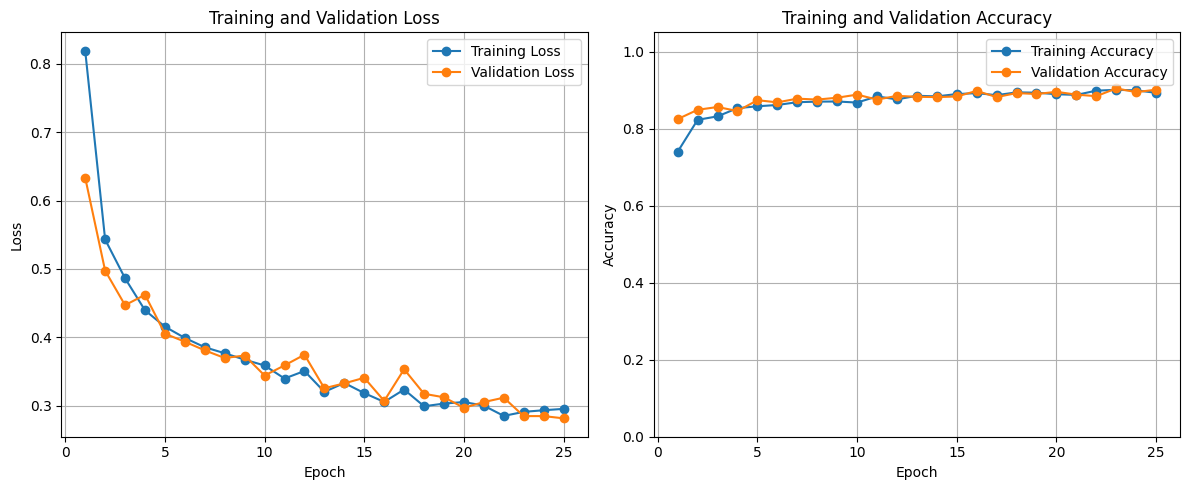

In [19]:
# %%
print("\nPlotting training and validation history...")

try:
    epochs_range = range(1, NUM_EPOCHS + 1) # Ensure x-axis matches epochs run

    plt.figure(figsize=(12, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    if history['train_loss'] and history['val_loss']: # Check if history has data
        plt.plot(epochs_range, history['train_loss'], marker='o', linestyle='-', label='Training Loss')
        plt.plot(epochs_range, history['val_loss'], marker='o', linestyle='-', label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss')
        plt.legend()
        plt.grid(True)
    else:
        plt.text(0.5, 0.5, 'No loss data to plot.', ha='center', va='center')


    # Plot Accuracy
    plt.subplot(1, 2, 2)
    if history['train_acc'] and history['val_acc']: # Check if history has data
        plt.plot(epochs_range, history['train_acc'], marker='o', linestyle='-', label='Training Accuracy')
        plt.plot(epochs_range, history['val_acc'], marker='o', linestyle='-', label='Validation Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.title('Training and Validation Accuracy')
        plt.legend()
        plt.grid(True)
        plt.ylim(0, 1.05) # Set y-axis limit for accuracy (0 to 1)
    else:
        plt.text(0.5, 0.5, 'No accuracy data to plot.', ha='center', va='center')


    plt.tight_layout()
    plt.show()
except Exception as e:
     print(f"Could not plot history: {e}")